In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import glob
import torch
import warnings
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from toolz.curried import pipe, curry, compose, memoize

In [3]:
from chnet.ch_losses import *
import chnet.ch_tools as ch_tools
import chnet.utilities as ch_utils
import chnet.ch_generator as ch_gen
from chnet.torchsummary import summary
from chnet.ch_loader import CahnHillDataset

In [4]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [5]:
%matplotlib inline  
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [6]:
def get_free_gpu():
    os.system('nvidia-smi -q -d Memory |grep -A4 GPU|grep Free >tmp')
    memory_available = [int(x.split()[2]) for x in open('tmp', 'r').readlines()]
    return np.argmax(memory_available)

In [7]:
@curry
def return_slice(x_data, cutoff):
    if cutoff is not None:
        return pipe(x_data,
                    lambda x_data: np.asarray(x_data.shape).astype(int) // 2,
                    lambda new_shape: [slice(new_shape[idim]-cutoff,
                                             new_shape[idim]+cutoff+1)
                                       for idim in range(x_data.ndim)],
                    lambda slices: x_data[slices])
    else:
        return x_data
    
cropper = return_slice(cutoff=5)

def draw_im(im, title=None):
    im = np.squeeze(im)
    plt.imshow(im)
    plt.colorbar()
    if title is not None:
        plt.title(title)
    plt.show()
    
    

def corr(x_data, y_data):
    return pipe(x_data, 
                lambda x: np.fft.fftn(x, axes=(0,1)), 
                lambda x: x * np.conj(np.fft.fftn(y_data, axes=(0,1))), 
                lambda x: np.fft.ifftn(x),
                lambda x: np.fft.fftshift(x), 
                lambda x: x.real) / x_data.size

In [8]:
# device = torch.device("cpu")
device = torch.device('cuda:{}'.format(get_free_gpu()) if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda:0


Elpsd Time: 6.812s, Dataset Shape: (32, 50, 96, 96)
mean conc. : 0.001


<IPython.core.display.Javascript object>


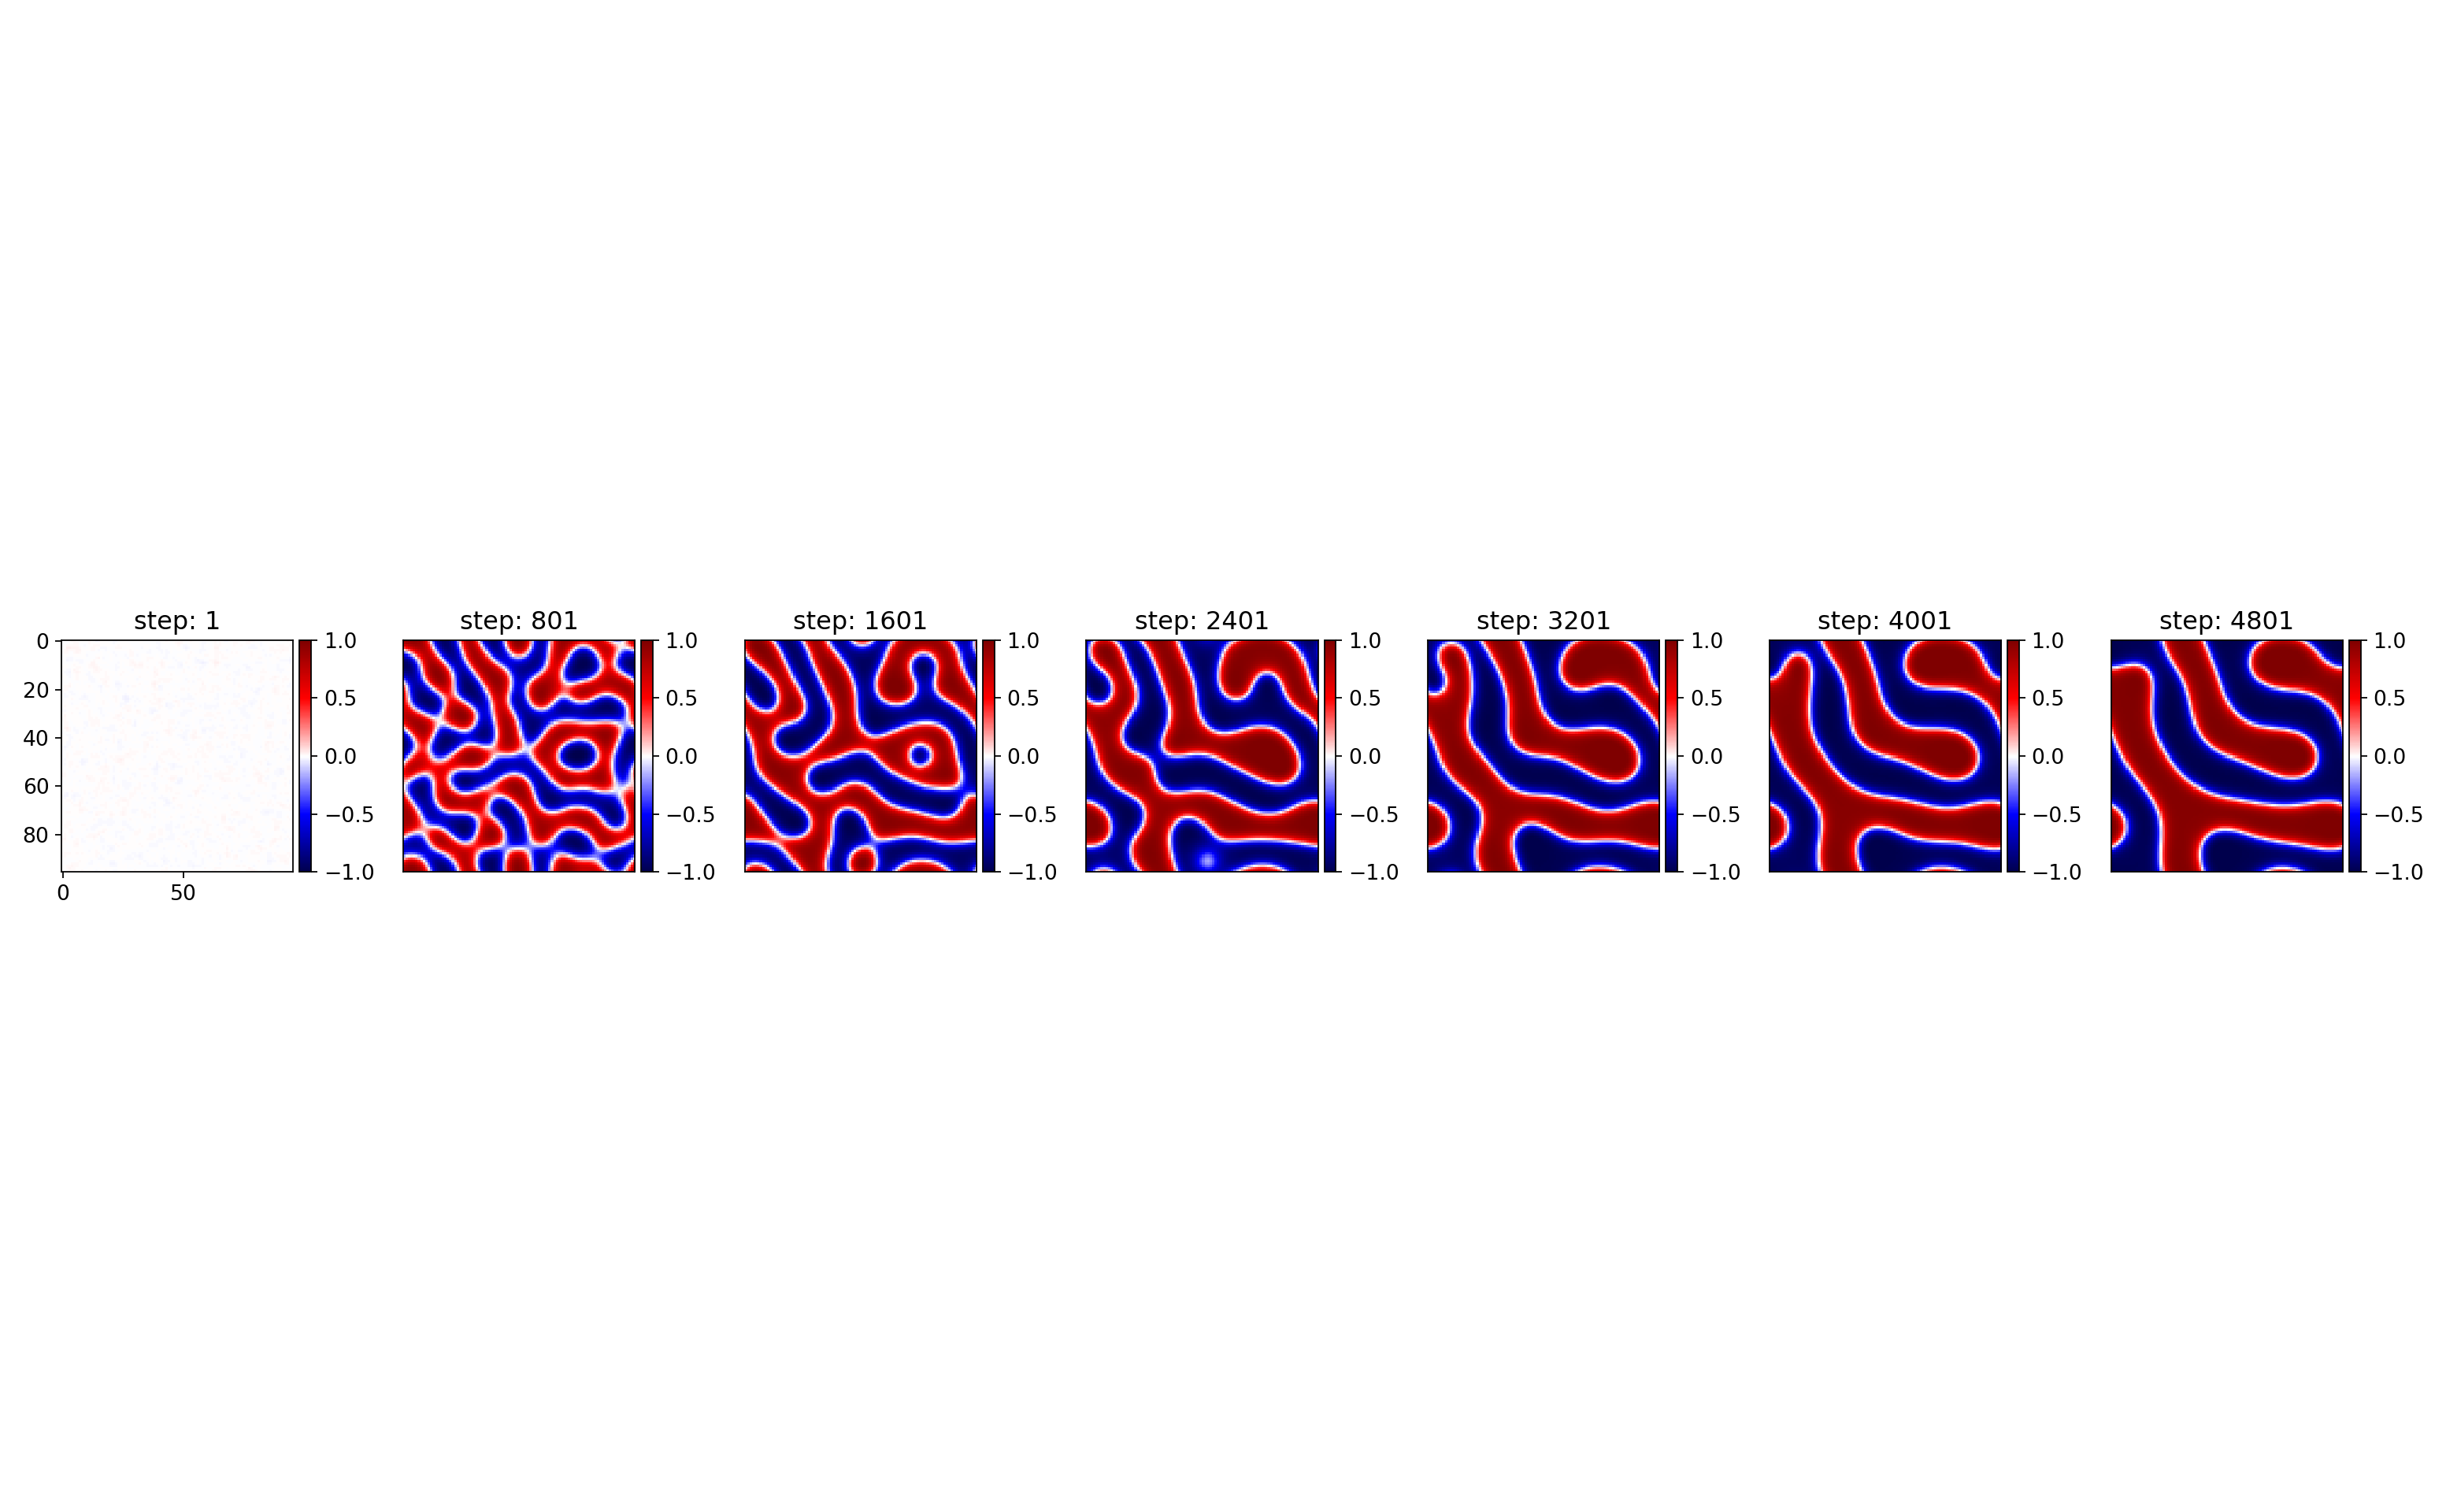

mean conc. : -0.001


<IPython.core.display.Javascript object>


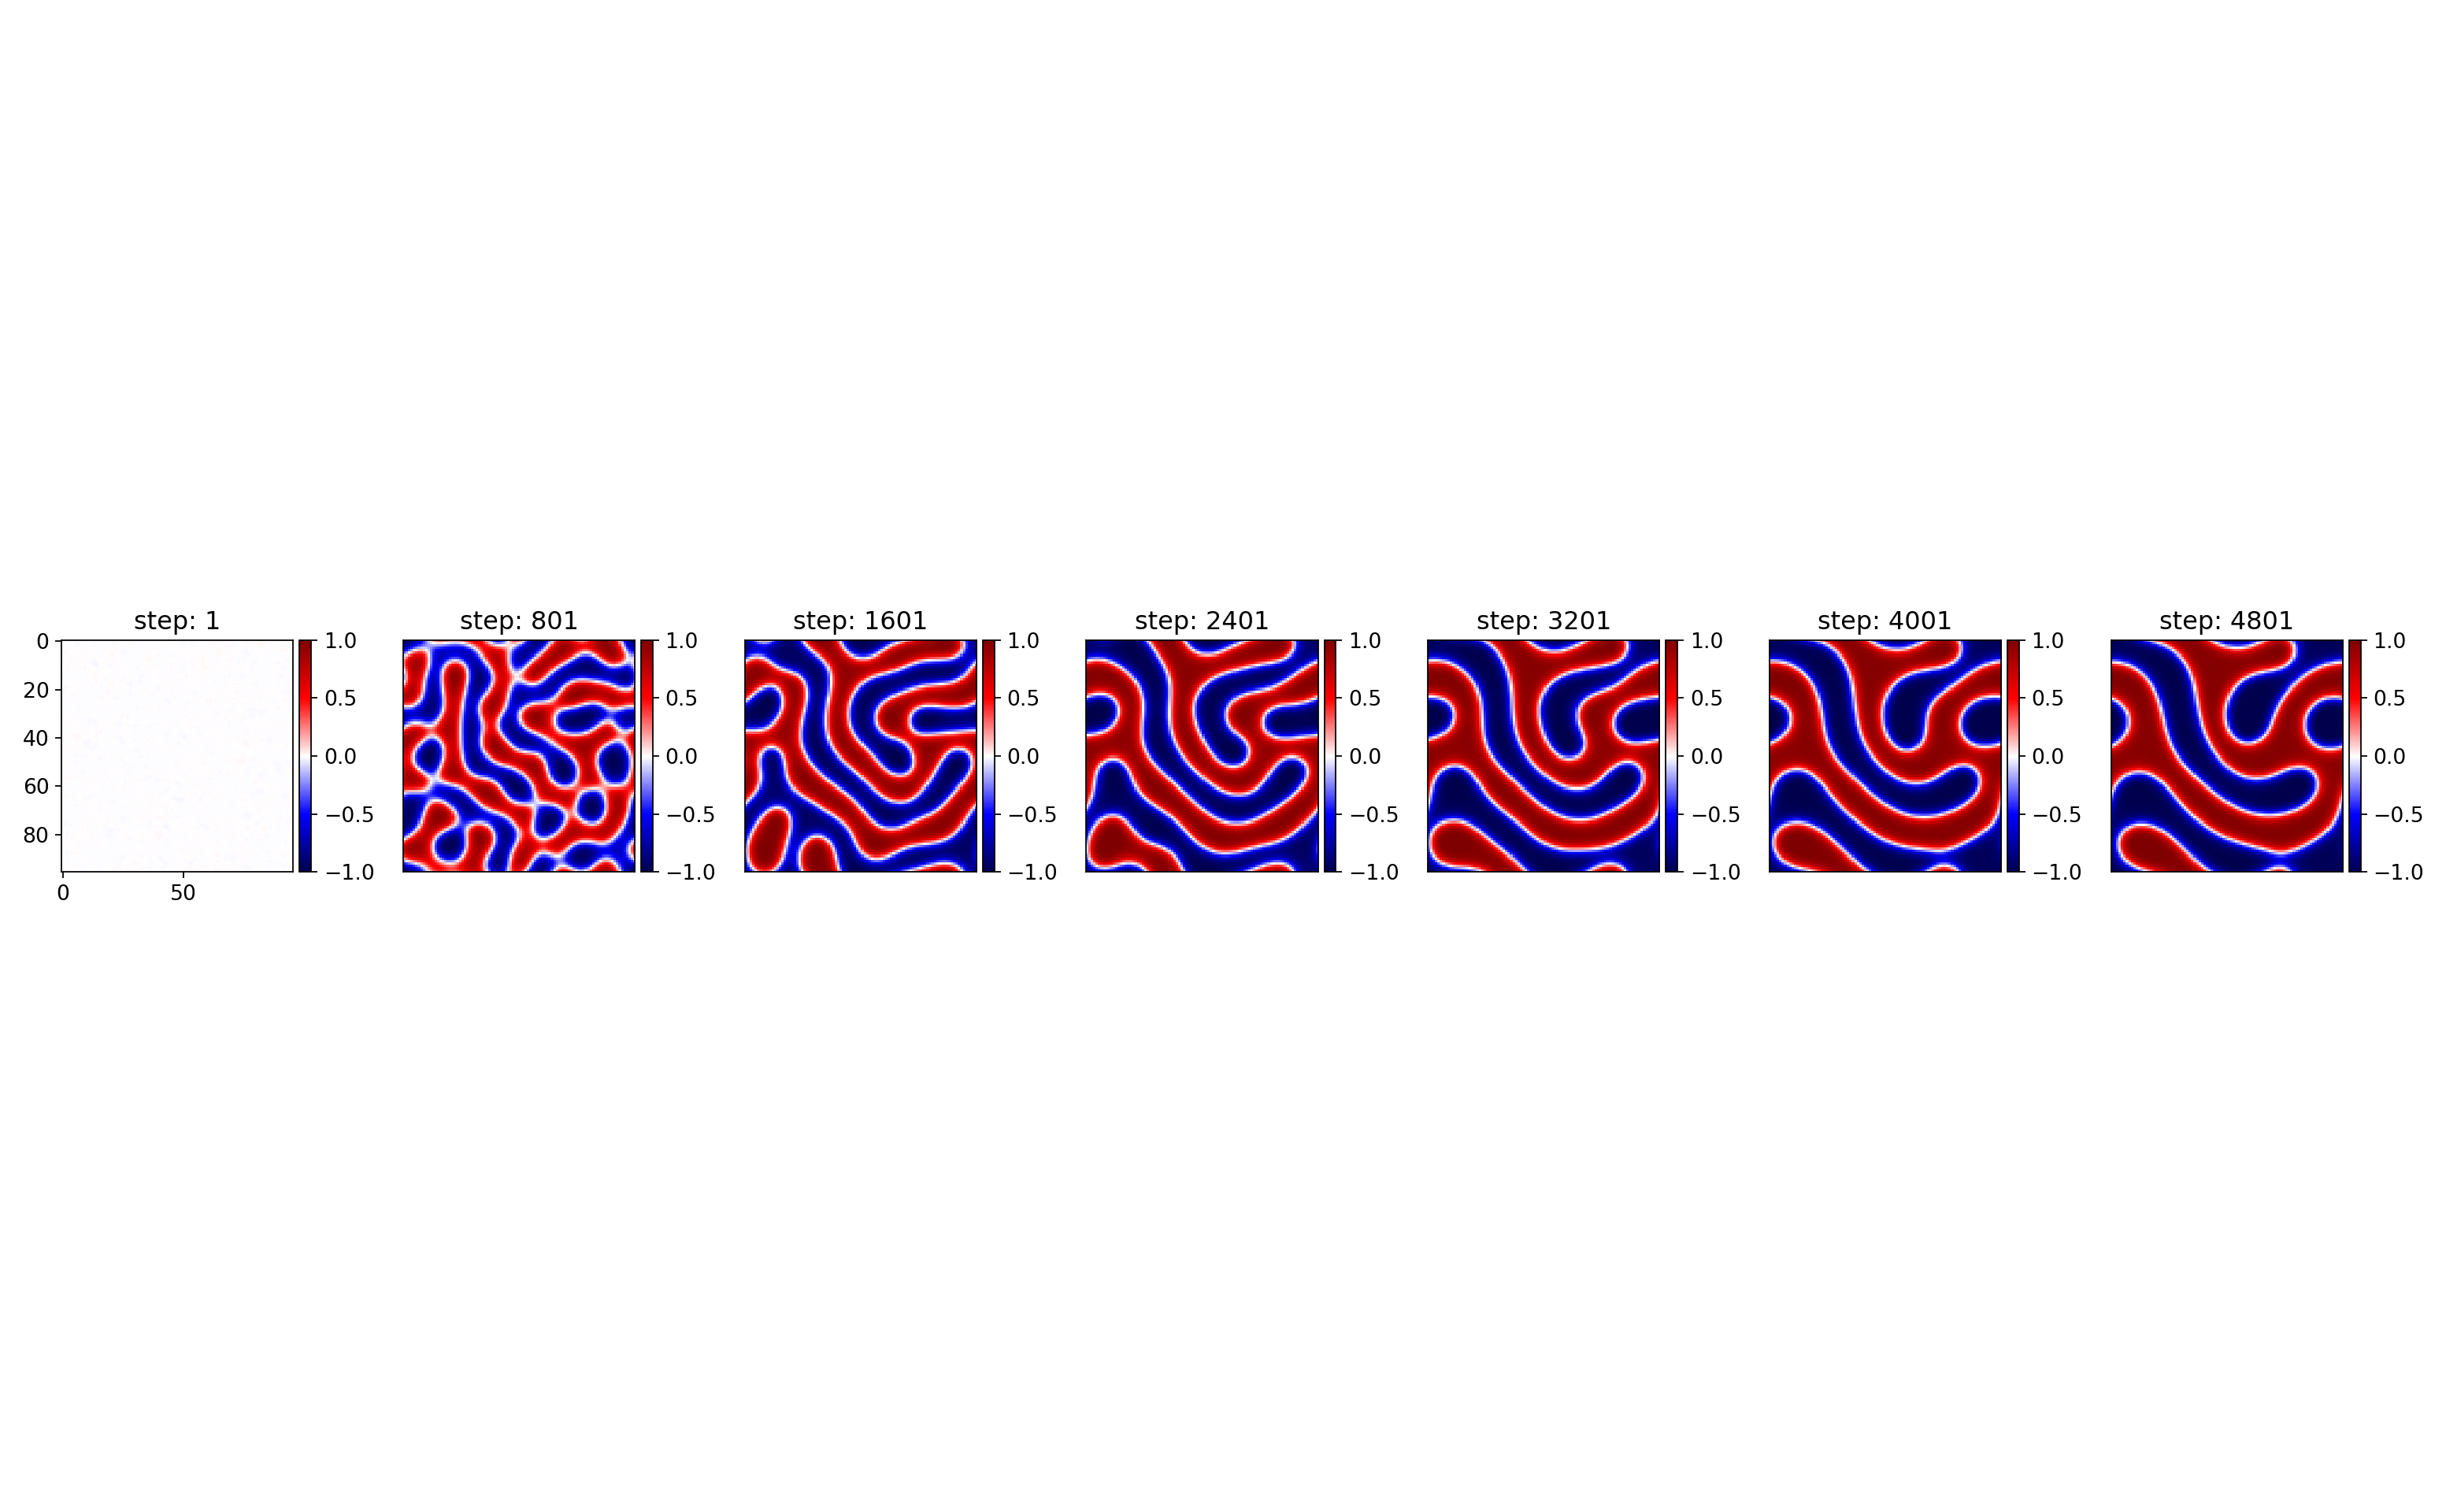

mean conc. : 0.000


<IPython.core.display.Javascript object>


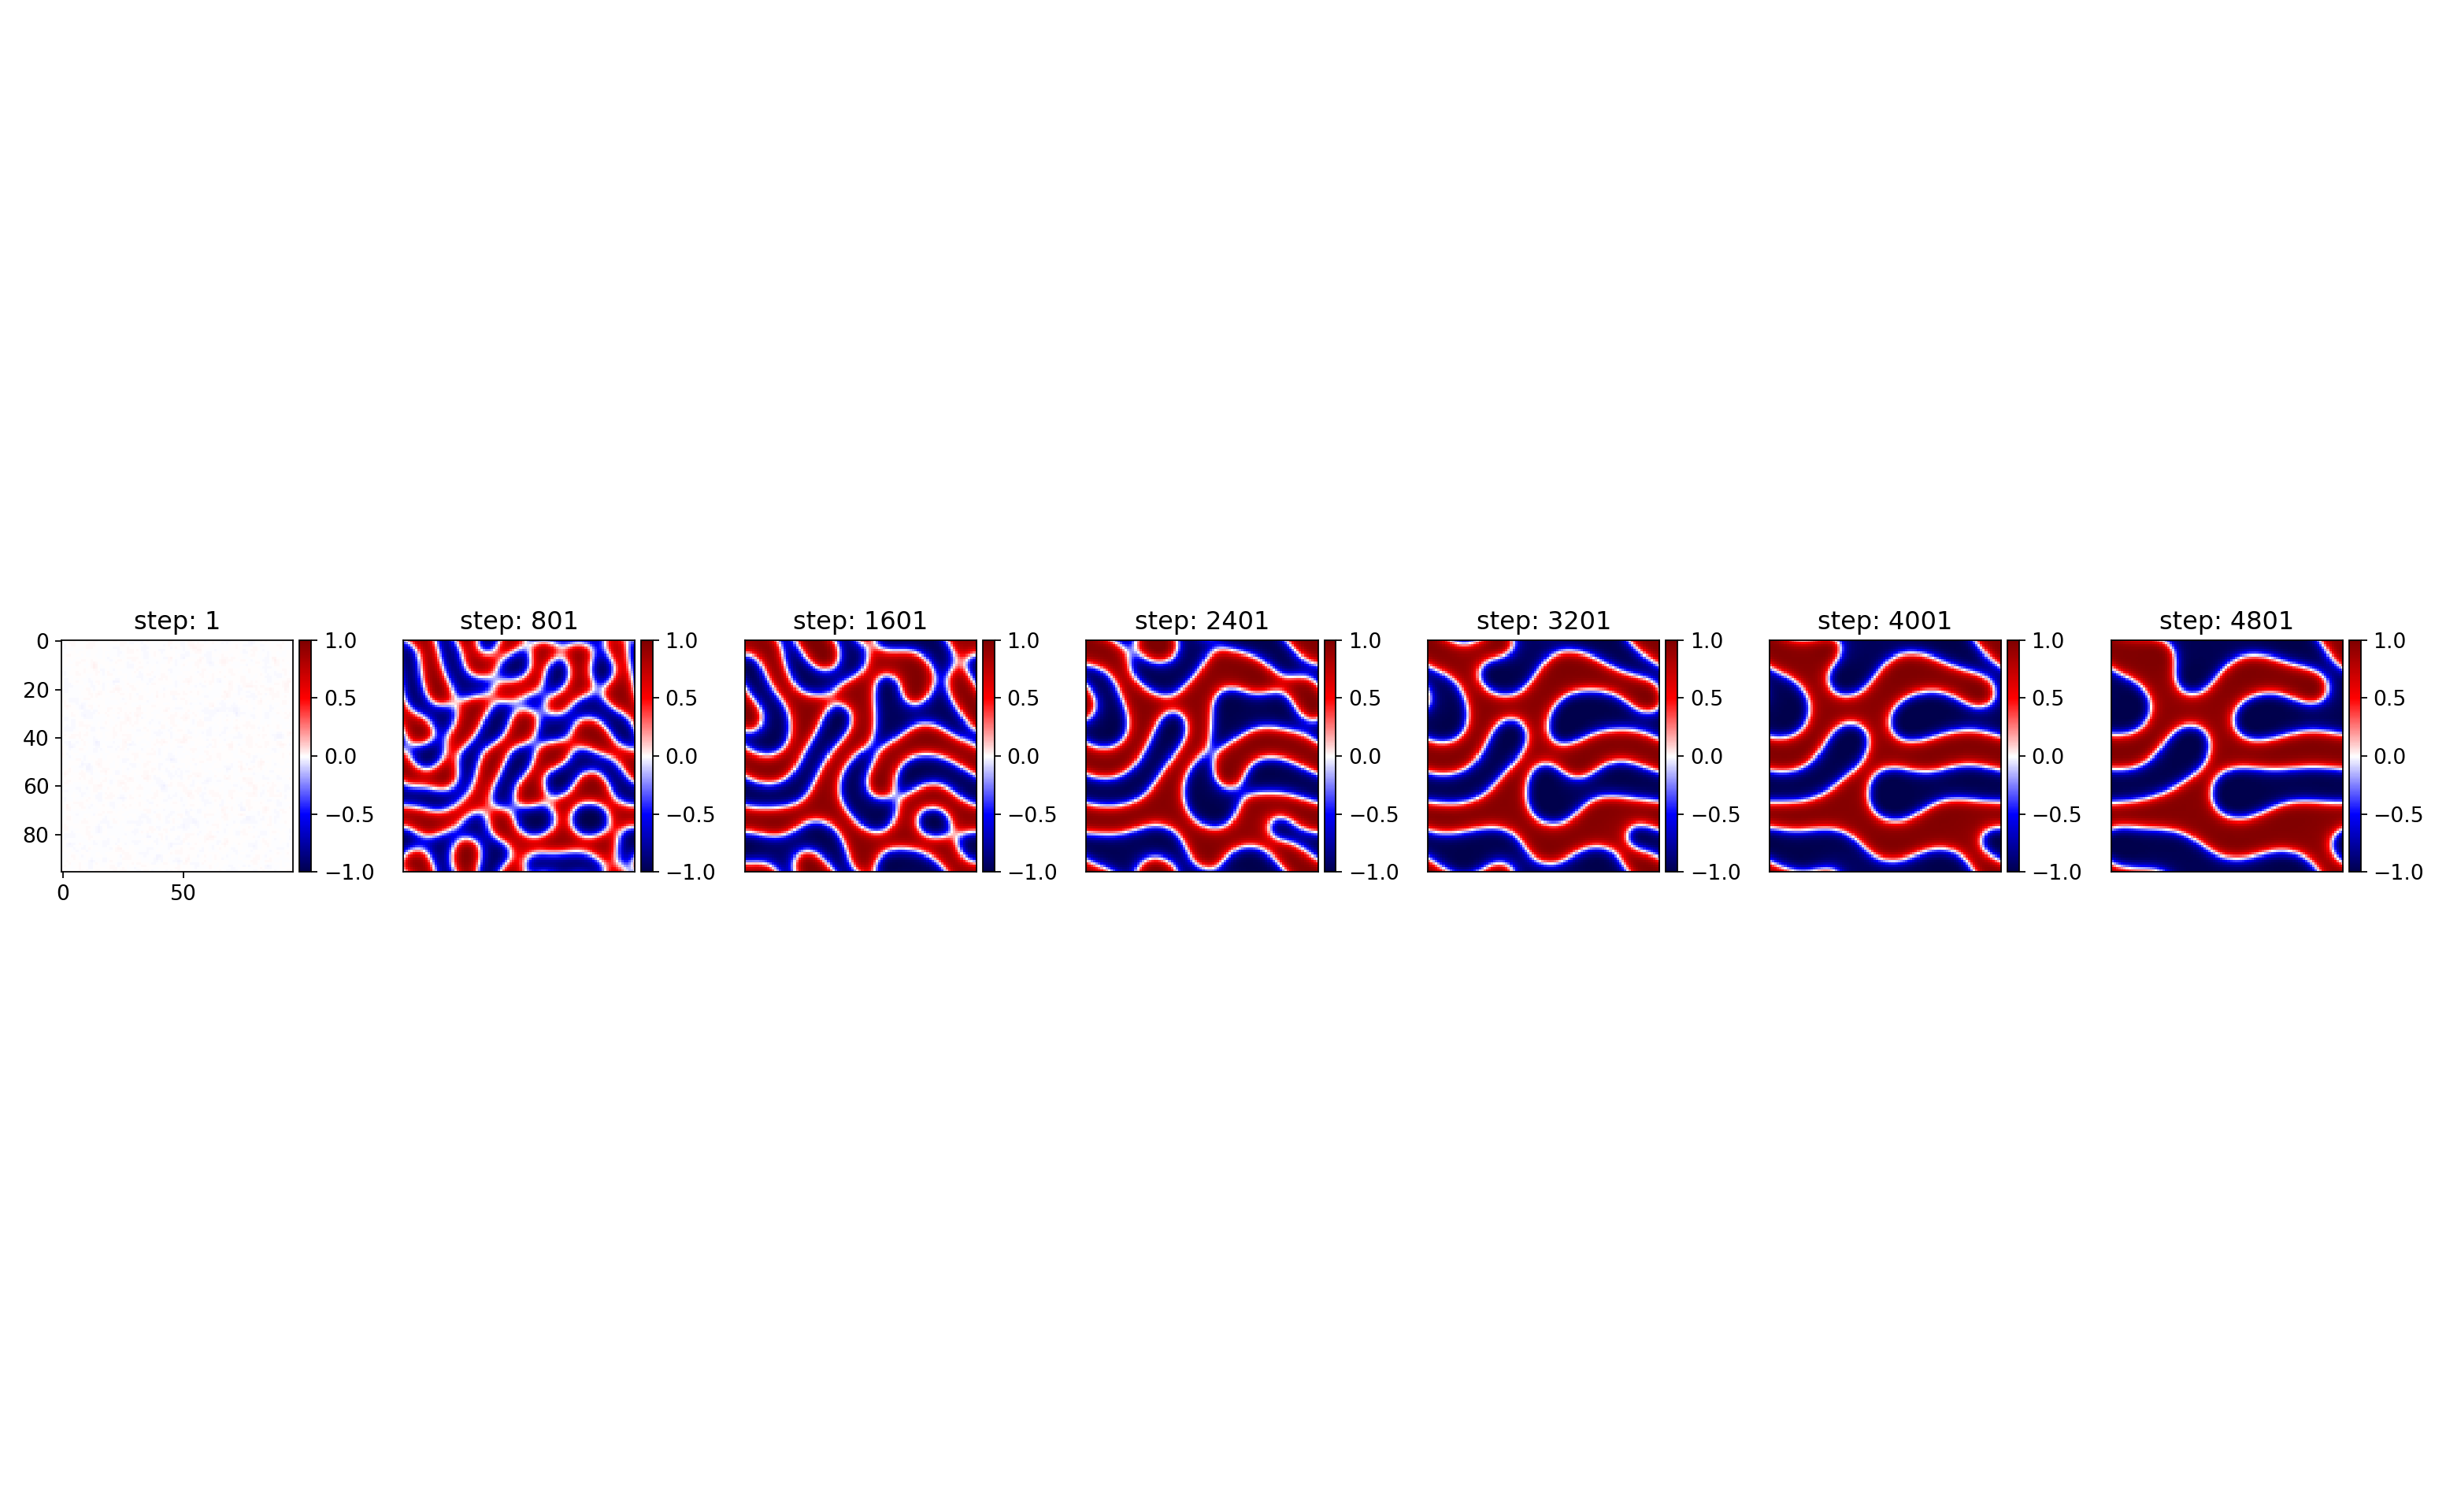

mean conc. : -0.001


<IPython.core.display.Javascript object>


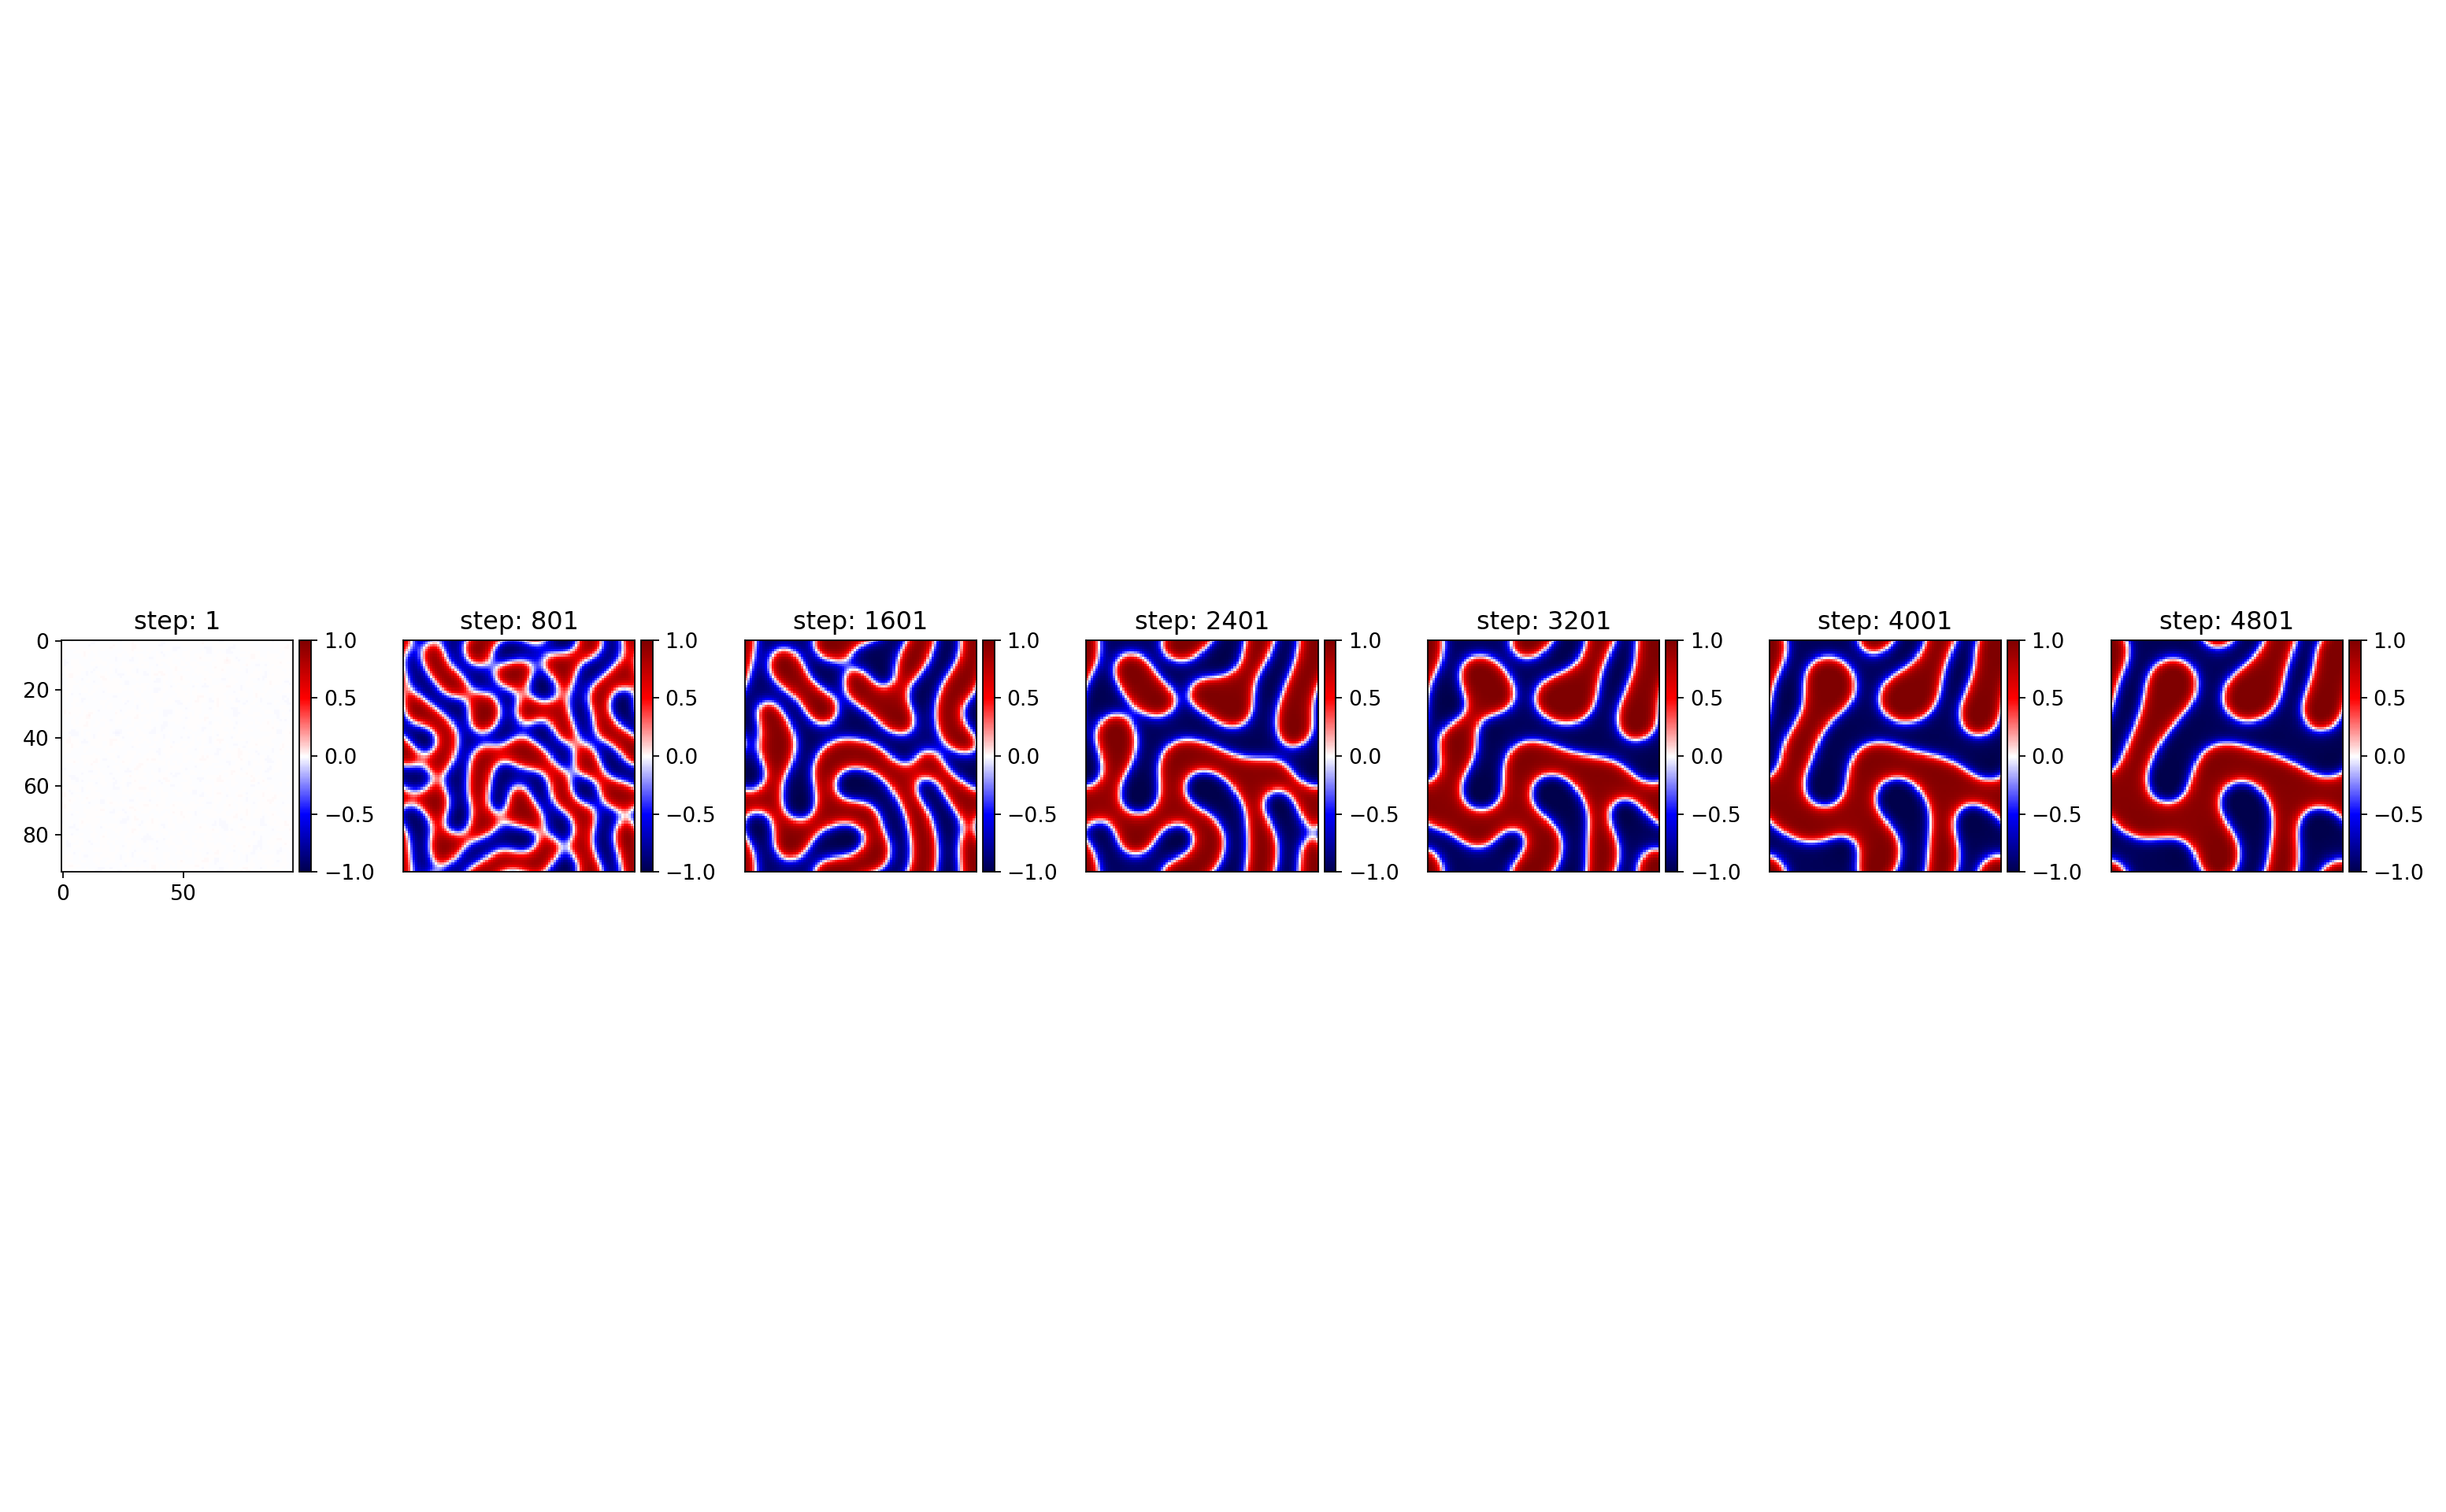

mean conc. : 0.000


<IPython.core.display.Javascript object>


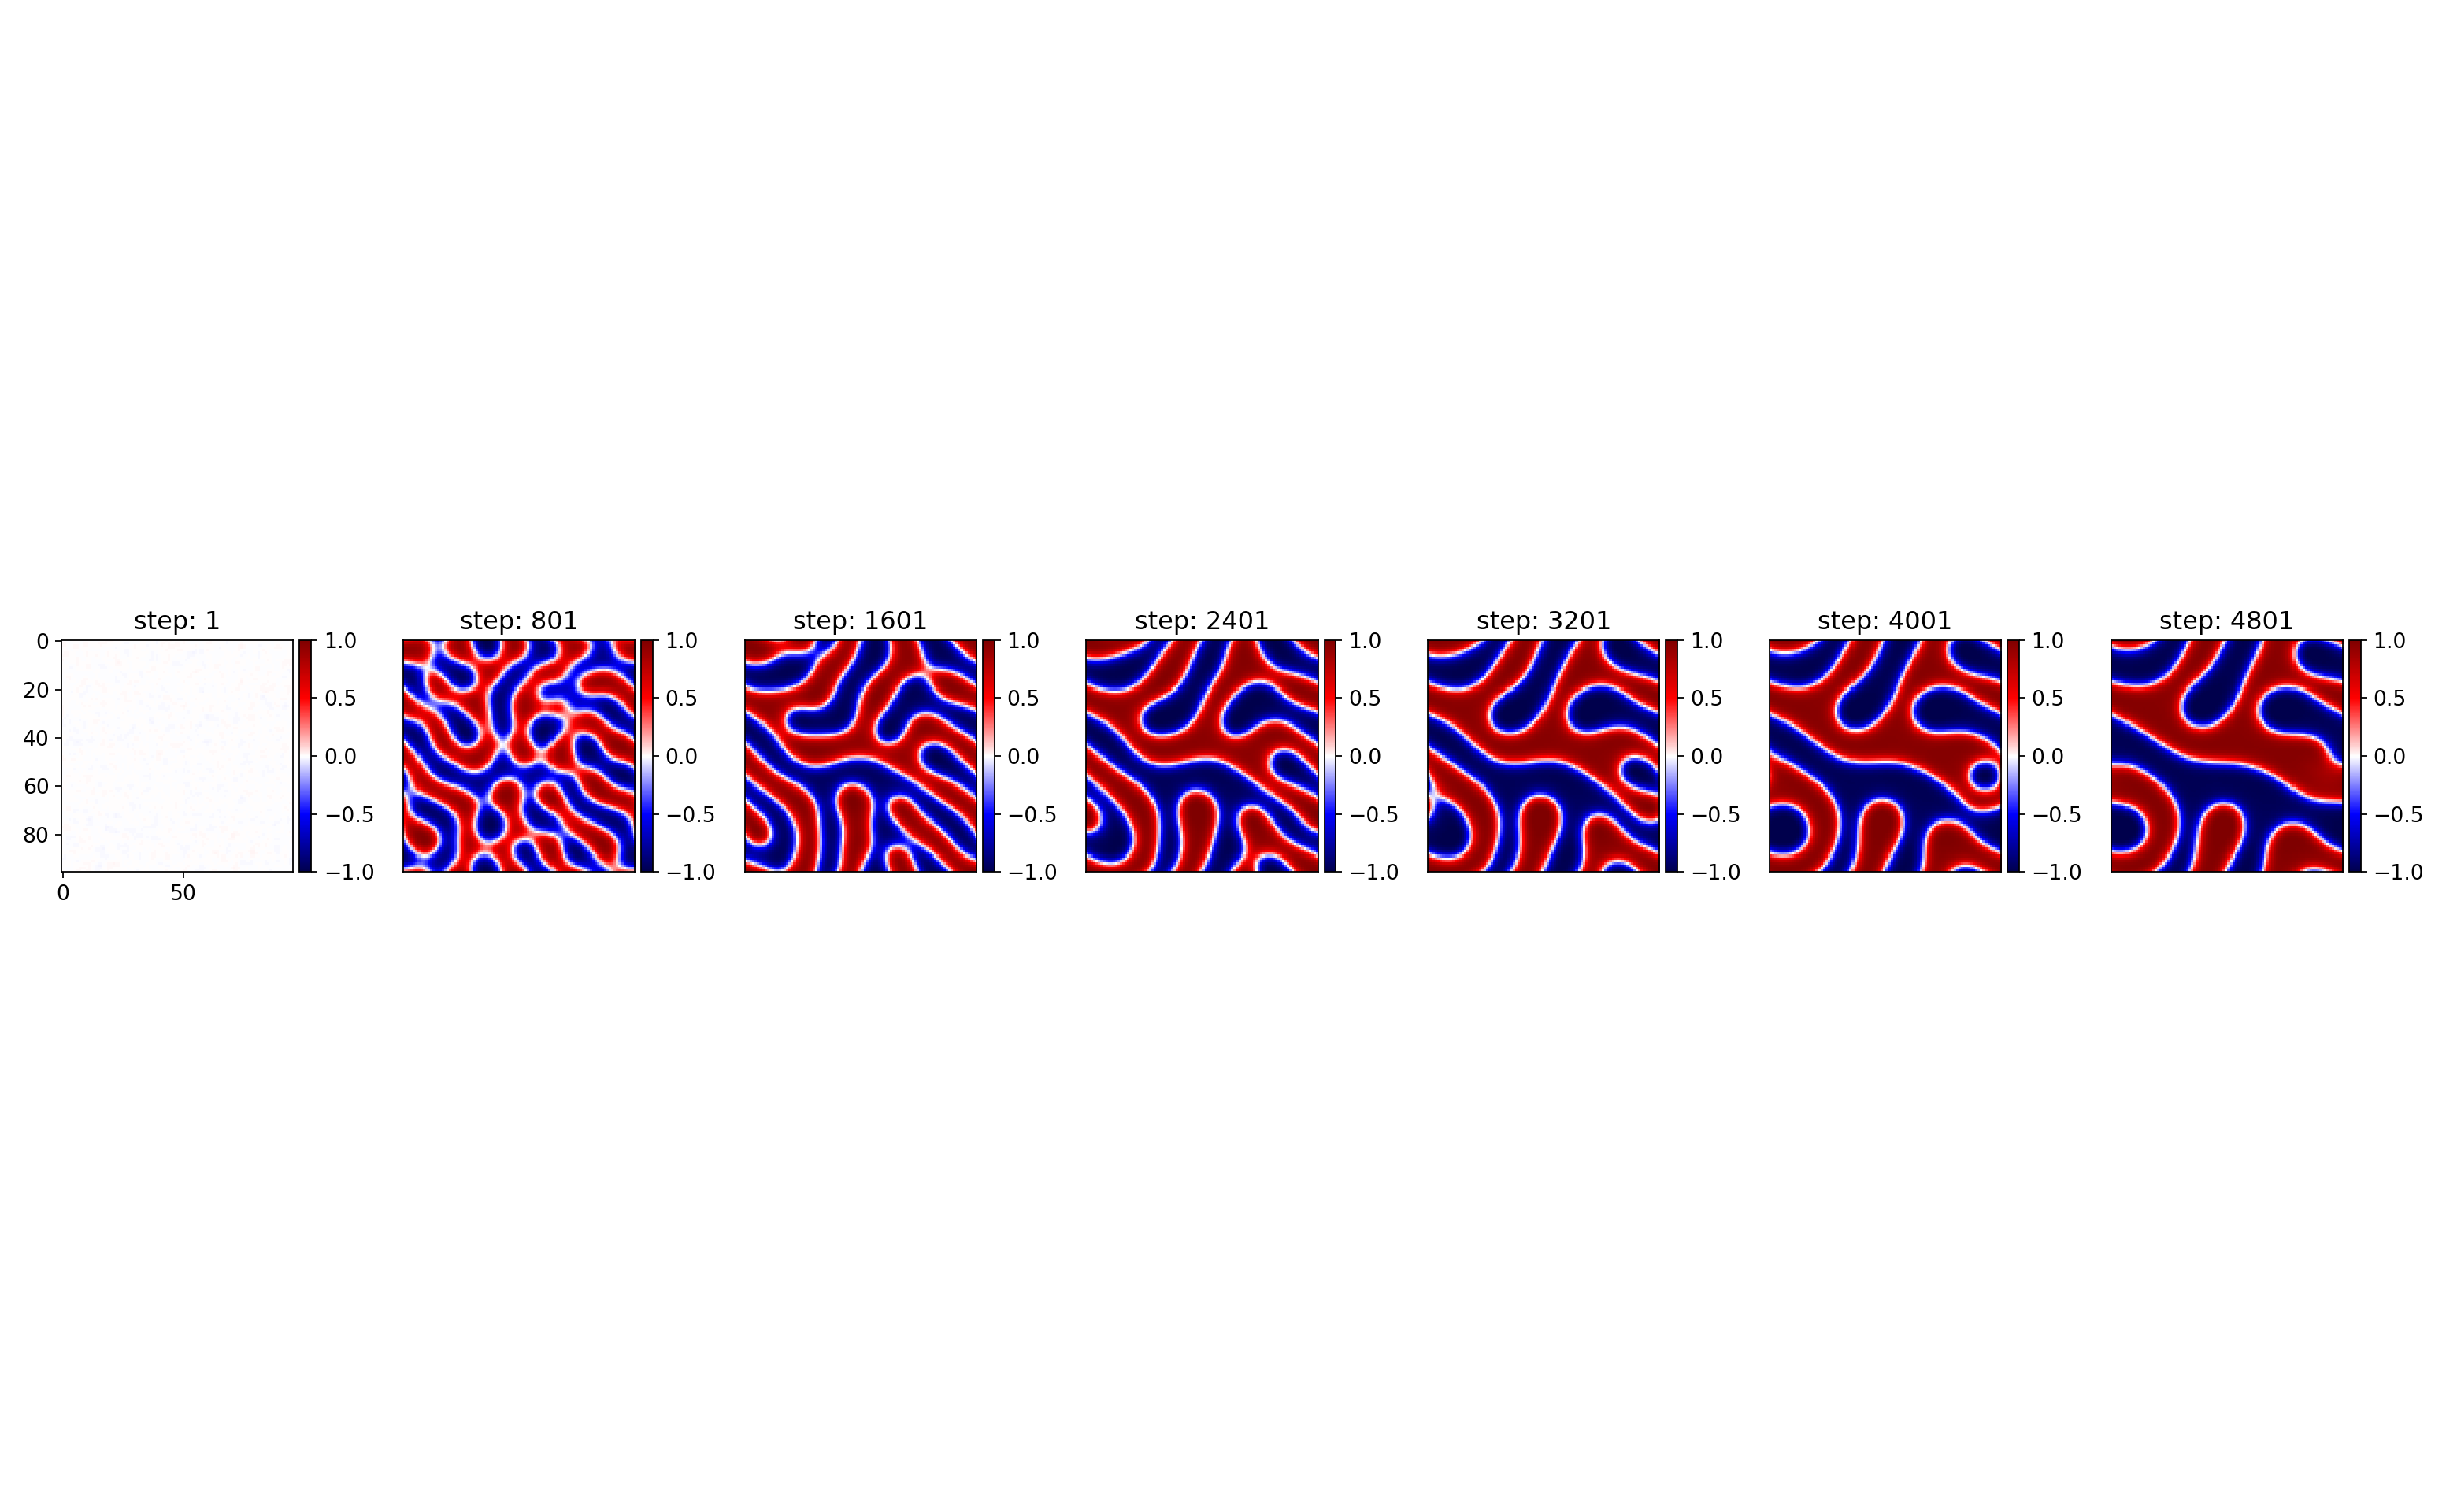

mean conc. : 0.001


<IPython.core.display.Javascript object>


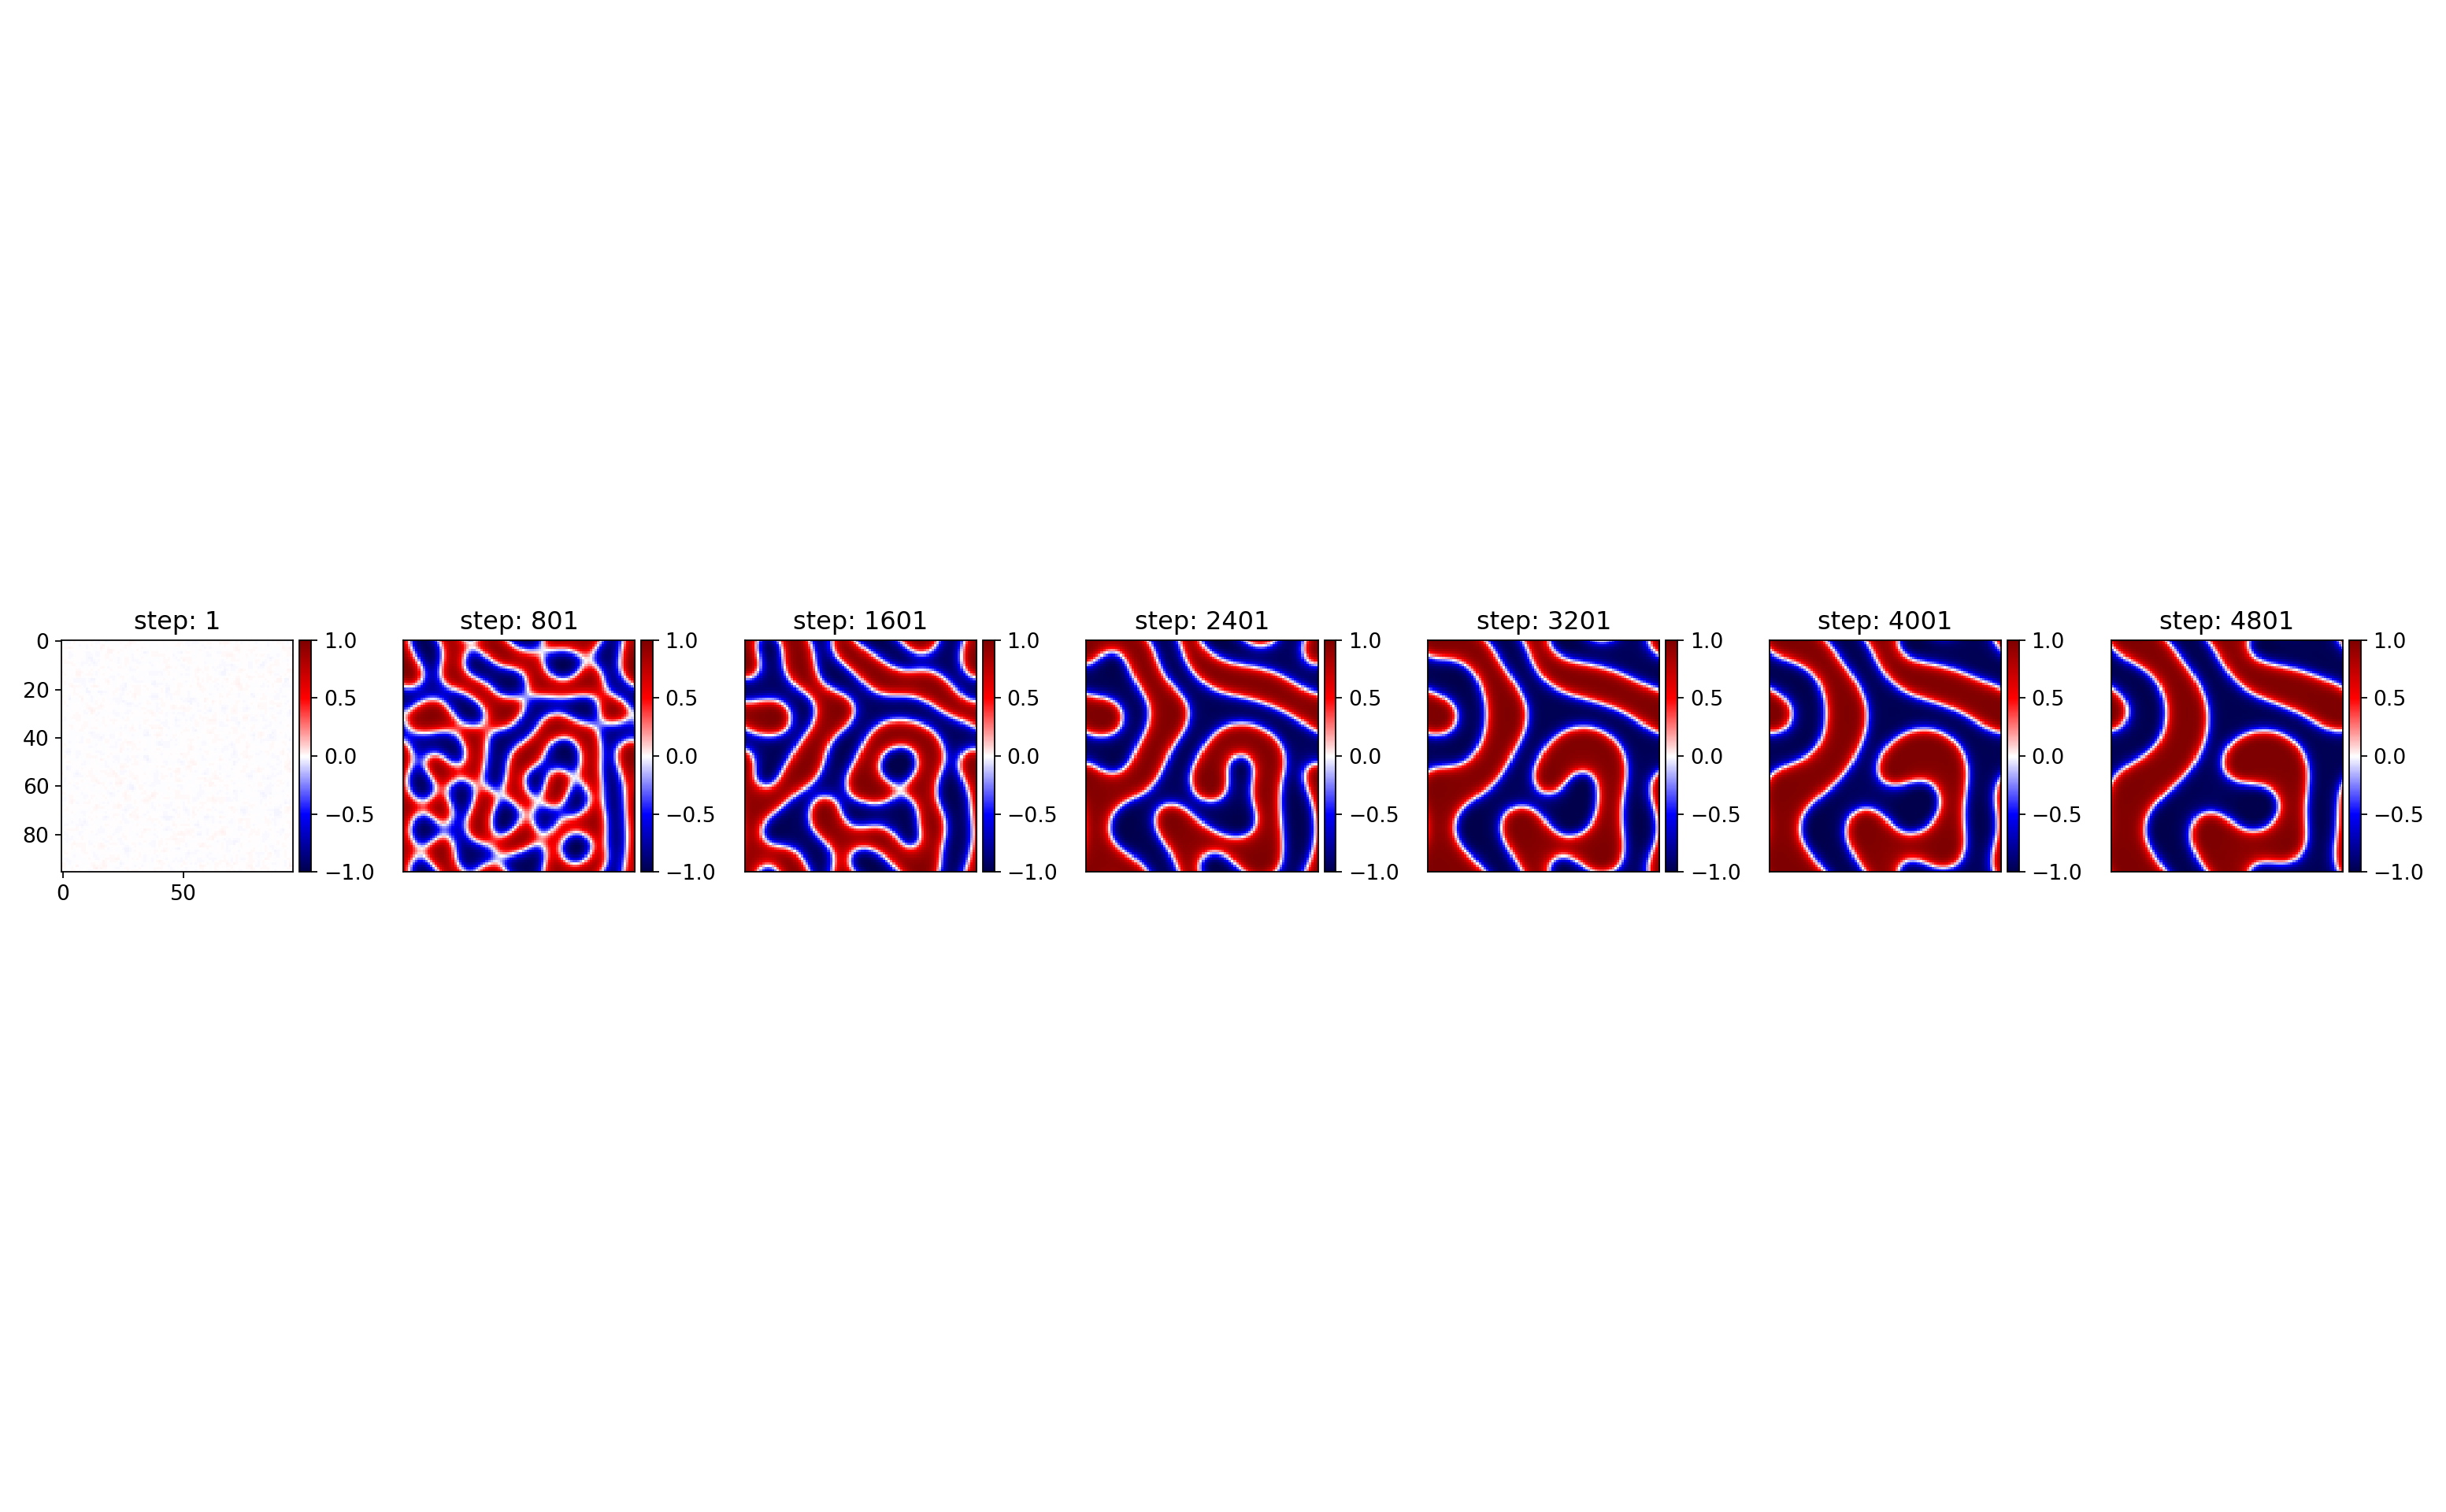

In [9]:
## Process Parameters
mid=0.0
dif=0.001
dim_x=96
init_steps=1
nstep=50
delta_sim_steps = 5000//nstep
dx=0.25 # not from paper
dt=0.01 # from paper
gamma=0.2 # from paper

seed_trn=110364
n_samples_val=32

strt = time.time()
x_data, _ = ch_gen.data_generator(nsamples=n_samples_val, 
                              dim_x=dim_x, 
                              init_steps=init_steps, 
                              delta_sim_steps = delta_sim_steps,
                              dx=dx, 
                              dt=dt,
                              m_l=mid-dif, 
                              m_r=mid+dif,
                              n_step=nstep,
                              gamma=gamma, 
                              seed=38921641,
                              device=device)

print("Elpsd Time: {:1.3f}s, Dataset Shape: {}".format(time.time()-strt, x_data.shape))

for iz in range(0, x_data.shape[0],  x_data.shape[0]//5):
    print("mean conc. : {:1.3f}".format(np.mean(x_data[iz][0])))
    ch_utils.draw_by_side([x_data[iz][ix] for ix in range(0, nstep, nstep//6)], 
                          sub_titles=["step: {}".format(delta_sim_steps*ix + 1) for ix in range(0, 50, 8)], 
                          scale=12)

# Microstructure Evolution in PC space

In [ ]:
import pymks
import warnings
import pandas as pd
import seaborn as sns
from pymks import LegendreBasis
from sklearn.decomposition import PCA
warnings.filterwarnings('ignore')

def plot_scatter(x1, x2, colors=None, lims=None, xlabel="", ylabel="", title="", cmap='RdYlBu', figsize=(10,10)):  
    import matplotlib.pyplot as plt
    cm = plt.cm.get_cmap(cmap)
    vmax = np.min(colors) if colors is not None else None
    vmin = np.max(colors) if colors is not None else None
    
    plt.figure(figsize=figsize)
    scatters = plt.scatter(x1, x2, c=colors, vmin=vmin, vmax=vmax, s=35, cmap=cm)
    plt.colorbar(scatters, fraction=0.046, pad=0.04)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim(lims)
    plt.ylim(lims)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.show()
    
def plot_scatter3d(x1, x2, x3, colors=None, lims=None, label="", ylabel="", zlabel="", title="", cmap='RdYlBu', figsize=(10,10)):  
    
    import matplotlib.pyplot as plt
    from mpl_toolkits import mplot3d
    
    cm = plt.cm.get_cmap(cmap)
    vmax = np.min(colors) if colors is not None else None
    vmin = np.max(colors) if colors is not None else None
    
    ax = plt.axes(projection='3d')
    scatters = ax.scatter3D(x1, x2, x3, c=colors, vmin=vmin, vmax=vmax, s=35, cmap=cm)
    plt.colorbar(scatters, fraction=0.046, pad=0.04)
#     plt.gca().set_aspect('equal', adjustable='box')
#     plt.xlim(lims)
#     plt.ylim(lims)
#     plt.zlim(lims)
    plt.show()
get_lims = lambda x: [np.min(x)-np.std(x), np.max(x)+np.std(x)]

In [ ]:

# import matplotlib.pyplot as plt
# from mpl_toolkits import mplot3d
# from IPython.display import HTML
# from matplotlib import animation

In [ ]:


# cm = plt.cm.get_cmap(cmap)
# vmax = np.min(colors) if colors is not None else None
# vmin = np.max(colors) if colors is not None else None

# ax = plt.axes(projection='3d')
# scatters = ax.scatter3D(scores[:,0], scores[:,1], scores[:,2], c=labels, s=35, cmap=cm)
# plt.colorbar(scatters, fraction=0.046, pad=0.04)
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')
# plt.show()

# def animate(frame):
#     ax.view_init(30, frame/4)
#     plt.pause(.001)
#     return fig

# anim = animation.FuncAnimation(fig, animate, frames=200, interval=50)
# HTML(anim.to_html5_video())

In [ ]:
%%time
nstep = 100
domain = [-1.1, 1.1]
n_states = 5
basis = LegendreBasis(n_states, domain)

correlations= []
for i0 in range(n_states-1):
    for i1 in range(i0, n_states-1):
        correlations.append((i0+1, i1+1))

print(correlations)
correlate = curry(pymks.stats.correlate)(basis=LegendreBasis(n_states, domain), 
                                         periodic_axes=[0,1], 
                                         correlations=correlations)

In [ ]:
mid = 0.1
x_data, _ = ch_gen.data_generator(nsamples=n_samples_val, 
                          dim_x=dim_x, 
                          init_steps=init_steps, 
                          delta_sim_steps = delta_sim_steps,
                          dx=dx, 
                          dt=dt,
                          m_l=mid-dif, 
                          m_r=mid+dif,
                          n_step=nstep,
                          gamma=gamma, 
                          seed=38921641,
                          device=device)

In [ ]:
slicer = return_slice(cutoff=25)
x_stat = correlate(x_data[0,:])

print(x_stat.shape)
for iz in range(x_stat.shape[0]):
    print("time step: {}".format(iz*delta_sim_steps+init_steps))
    ch_utils.draw_by_side([x_data[0,iz],]+[slicer(x_stat[iz,:,:,ix]) for ix in [0,1,2,3,4]], 
                          scale=12, 
                          vmin=None, vmax=None)

In [ ]:
reshape = curry(np.reshape)(newshape=(n_samples_val, -1))

generator = lambda mid: ch_gen.data_generator(nsamples=n_samples_val, 
                          dim_x=dim_x, 
                          init_steps=init_steps, 
                          delta_sim_steps = delta_sim_steps,
                          dx=dx, 
                          dt=dt,
                          m_l=mid-dif, 
                          m_r=mid+dif,
                          n_step=nstep,
                          gamma=gamma, 
                          seed=38921641,
                          device=device)[0]

gen_stat = compose(reshape, correlate)

In [ ]:
mid = 0.1
x_data = generator(mid)
stats = np.concatenate([gen_stat(x_data[:,ix])for ix in tqdm(range(nstep))], axis=0)
scores = PCA(n_components=10).fit_transform(stats)
labels = np.ravel([[ix+1]*n_samples_val for ix in range(nstep)])
plot_scatter(scores[:,0], scores[:,1], colors=labels, lims=get_lims(scores[:,0]), cmap="magma", xlabel="PC 1", ylabel="PC 2")
plot_scatter(scores[:,0], scores[:,2], colors=labels, lims=get_lims(scores[:,0]), cmap="magma", xlabel="PC 1", ylabel="PC 3")
plot_scatter(scores[:,1], scores[:,2], colors=labels, lims=get_lims(scores[:,1]), cmap="magma", xlabel="PC 2", ylabel="PC 3")

In [ ]:
%%time
scores = {}
for mid in np.arange(-.4, .4, .1):
    print(mid)
    x_data = generator(mid)
    stats = np.concatenate([gen_stat(x_data[:,ix])for ix in tqdm(range(nstep))], axis=0)
    scores[mid] = PCA(n_components=10).fit_transform(stats)

In [ ]:
get_dist = lambda x: np.sqrt(np.sum((x - x.mean(axis=0))**2, axis=1))

In [ ]:
dfs = []
init = 5
skip = 1
tsteps = init+5
for key in scores.keys():    
    dists = {}
    for t, i0 in enumerate(range(n_samples_val*init, n_samples_val*tsteps, n_samples_val*skip)):
        x = scores[key][i0:i0+32]
        dists[t*delta_sim_steps*skip+init_steps] = get_dist(x)
    df = pd.melt(pd.DataFrame(dists))
    df["hue"] = ["{:1.1f}".format(key)]*len(df)
    dfs.append(df)
    
dfs = pd.concat(dfs)

In [ ]:
plt.figure(figsize=(18, 12))
sns.boxplot(x="variable", y="value", hue="hue", data=dfs)
plt.show()